In [1]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import torch
from transformers import AutoTokenizer, AutoModel

tqdm.pandas()

device = torch.device('cuda')

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_excel('../Выгрузка_Классификатор_для передачи_1 заход.xlsx')

In [3]:
data

,Номер,Пол,Дата рождения,Федеральный округ,Регион,Страна проживания,Место работы,Наименование текущей должности,Уровень образования,Карьерная ступень по Классификатору ФОИР,Наименование выбранной типовой должности,Сфера деятельности по Классификатору ФОИР,Соответствует ли выбранная типовая текущей должности,Ручная проверка карьерной ступени,Разница по итогам проверки
0,9886272994,Мужской,28.05.1980,Центральный ФО,Московская,Россия,"ООО ""РЖД-Технологии""",Директор по стратегии,Кандидат наук,1,Руководитель подразделения/группы/команды на м...,"Коммерческие компании, государственные/муницип...",Можно считать аналогом с очень большой натяжкой,NaN,NaN
1,8010695393,Мужской,09.10.1977,Центральный ФО,Орловская,Россия,ПАО МегаФон,начальник,Два и более высших образований,3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN
2,4851605917,Мужской,08.12.1991,Уральский ФО,Свердловская,Россия,"ООО ""Генная Хирургия""",Исполнительный директор,Два и более высших образований,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN
3,4093896163,Мужской,18.07.1973,Северо-Западный ФО,Санкт-Петербург,Россия,"ООО ""Спецстроймонтаж""; ООО ""СЕРВИС ТИМ""; ООО ""...",Исполнительный директор; Генеральный директор;...,Два и более высших образований,2,Директор малого предприятия,"Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN
4,7512508692,Мужской,19.01.1980,Центральный ФО,Москва,Россия,ПАО «Вымпелком»,Директор по стратегии и долгосрочному планиров...,"Высшее, специалитет, магистратура",4,Руководитель управления корпоративной функции ...,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75234,5143980152,Мужской,03.09.1967,NaN,NaN,Эстония,ООО Стивтранс,Член правления,Два и более высших образований,2,Директор малого предприятия,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN
75235,7339537870,Мужской,17.03.1995,Центральный ФО,Белгородская,Россия,NaN,NaN,Два и более высших образований,12,Не работаю,Не работаю,Не работаю,NaN,NaN
75236,3799741744,Мужской,12.08.1995,NaN,NaN,Таджикистан,РУДН,Врач-ординатор РУДН,Два и более высших образований,12,Не работаю,Не работаю,Полный аналог,NaN,NaN
75237,9663315939,Мужской,11.01.1982,NaN,NaN,Казахстан,Группа инженерных компаний Интерконд,Управляющий партнер,"Высшее, специалитет, магистратура",5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN


In [4]:
data.nunique()

Номер                                                   75239
Пол                                                         2
Дата рождения                                           12930
Федеральный округ                                           8
Регион                                                     86
Страна проживания                                         131
Место работы                                            52556
Наименование текущей должности                          33351
Уровень образования                                        10
Карьерная ступень по Классификатору ФОИР                   12
Наименование выбранной типовой должности                  169
Сфера деятельности по Классификатору ФОИР                   8
Соответствует ли выбранная типовая текущей должности        5
Ручная проверка карьерной ступени                          11
Разница по итогам проверки                                 12
dtype: int64

In [5]:
data['Наименование выбранной типовой должности'].value_counts()

Наименование выбранной типовой должности
Не работаю                                                                                                                                           6250
Руководитель подразделения/группы/команды на малом предприятии/организации (малый бизнес)                                                            6248
Руководитель структурного подразделения (начальник отдела)/группы/команды на крупном предприятии/организации (федеральный уровень/крупный бизнес)    6165
Руководитель подразделения (начальник отдела) на среднем предприятии/организации (региональный уровень/средний бизнес)                               5306
Руководитель проекта в крупной/средней компании                                                                                                      4822
                                                                                                                                                     ... 
Руководитель администрации субъекта

In [6]:
data['Место работы'].value_counts()

Место работы
ПАО Сбербанк                                               617
Сбербанк                                                   165
Индивидуальный предприниматель                             156
ИП                                                         128
ОАО "РЖД"                                                  127
                                                          ... 
ЗАО «АМ СПб»                                                 1
Fresh Auto                                                   1
АО РНПК                                                      1
Отделение-НБ Республика Дагестан Южного ГУ Банка России      1
ИП Адушкин С.А.                                              1
Name: count, Length: 52556, dtype: int64

In [11]:
pd.Timestamp('now').year - data['age'].mean()

1984.5057188554224

In [7]:
data['Дата рождения'] = pd.to_datetime(data['Дата рождения'], format="%d.%m.%Y")
data['age'] = pd.Timestamp('now').year - data['Дата рождения'].dt.year



LE = LabelEncoder()
data['label'] = LE.fit_transform(data['Сфера деятельности по Классификатору ФОИР'])
# data['label'] = LE.fit_transform(data['Карьерная ступень по Классификатору ФОИР'])

text_cols  = ['Место работы', 'Наименование текущей должности', 'Наименование выбранной типовой должности',]
cat_cols = ['age', 'Пол', 'Регион', 'Страна проживания', 'Уровень образования', 'Соответствует ли выбранная типовая текущей должности']
data[text_cols] = data[text_cols].fillna('Пропущенное значение')

In [6]:
df = data[data['Ручная проверка карьерной ступени'].notna()]
df_train, df_val, y_train, y_val= train_test_split(df[cat_cols + text_cols], df['label'], random_state=42)

In [7]:
df = data.copy()

df_val = df[df['Ручная проверка карьерной ступени'].notna()][cat_cols + text_cols]
y_val = df[df['Ручная проверка карьерной ступени'].notna()]['label']

df_train = df[df['Ручная проверка карьерной ступени'].isna()][cat_cols + text_cols]
y_train = df[df['Ручная проверка карьерной ступени'].isna()]['label']

In [8]:
# df = df.fillna('NaN')

In [9]:
df.nunique()

Номер                                                   75239
Пол                                                         2
Дата рождения                                           12930
Федеральный округ                                           8
Регион                                                     86
Страна проживания                                         131
Место работы                                            52557
Наименование текущей должности                          33352
Уровень образования                                        10
Карьерная ступень по Классификатору ФОИР                   12
Наименование выбранной типовой должности                  169
Сфера деятельности по Классификатору ФОИР                   8
Соответствует ли выбранная типовая текущей должности        5
Ручная проверка карьерной ступени                          11
Разница по итогам проверки                                 12
age                                                        44
label   

Посмотрим распределение таргета

<Axes: >

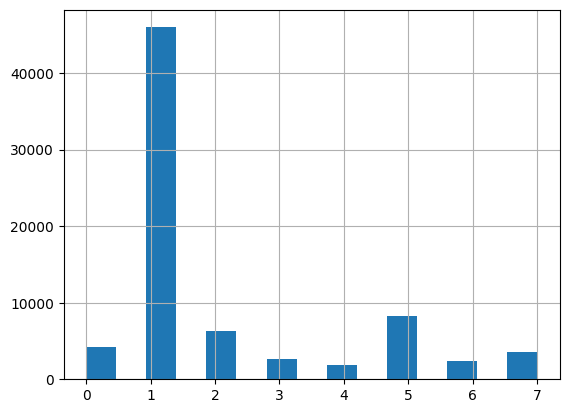

In [10]:
df['label'].hist(bins=15)

In [11]:
df['Ручная проверка карьерной ступени']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
75234   NaN
75235   NaN
75236   NaN
75237   NaN
75238   NaN
Name: Ручная проверка карьерной ступени, Length: 75239, dtype: float64

## Создадим категориальные фичи 
(Возраст, Пол, Регион, Страна проживания, Уровень образования, Соответствует ли выбранная типовая текущей должности)

In [12]:
cat_transformer = ColumnTransformer([('encoder', OrdinalEncoder(encoded_missing_value=-1), cat_cols)], remainder='passthrough', verbose_feature_names_out=True)
cat_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder',
                                 OrdinalEncoder(encoded_missing_value=-1),
                                 ['age', 'Пол', 'Регион', 'Страна проживания',
                                  'Уровень образования',
                                  'Соответствует ли выбранная типовая текущей '
                                  'должности'])])

In [13]:
cat_transformer.fit_transform(df)

,encoder__age,encoder__Пол,encoder__Регион,encoder__Страна проживания,encoder__Уровень образования,encoder__Соответствует ли выбранная типовая текущей должности,remainder__Номер,remainder__Дата рождения,remainder__Федеральный округ,remainder__Место работы,remainder__Наименование текущей должности,remainder__Карьерная ступень по Классификатору ФОИР,remainder__Наименование выбранной типовой должности,remainder__Сфера деятельности по Классификатору ФОИР,remainder__Ручная проверка карьерной ступени,remainder__Разница по итогам проверки,remainder__label
0,23.0,1.0,43.0,91.0,5.0,0.0,9886272994,1980-05-28,Центральный ФО,"ООО ""РЖД-Технологии""",Директор по стратегии,1,Руководитель подразделения/группы/команды на м...,"Коммерческие компании, государственные/муницип...",NaN,NaN,1
1,26.0,1.0,51.0,91.0,3.0,3.0,8010695393,1977-10-09,Центральный ФО,ПАО МегаФон,начальник,3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",NaN,NaN,1
2,12.0,1.0,63.0,91.0,3.0,4.0,4851605917,1991-12-08,Уральский ФО,"ООО ""Генная Хирургия""",Исполнительный директор,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",NaN,NaN,1
3,30.0,1.0,59.0,91.0,3.0,4.0,4093896163,1973-07-18,Северо-Западный ФО,"ООО ""Спецстроймонтаж""; ООО ""СЕРВИС ТИМ""; ООО ""...",Исполнительный директор; Генеральный директор;...,2,Директор малого предприятия,"Коммерческие компании, государственные/муницип...",NaN,NaN,1
4,23.0,1.0,42.0,91.0,2.0,3.0,7512508692,1980-01-19,Центральный ФО,ПАО «Вымпелком»,Директор по стратегии и долгосрочному планиров...,4,Руководитель управления корпоративной функции ...,"Коммерческие компании, государственные/муницип...",NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75234,36.0,1.0,-1.0,126.0,3.0,3.0,5143980152,1967-09-03,NaN,ООО Стивтранс,Член правления,2,Директор малого предприятия,"Коммерческие компании, государственные/муницип...",NaN,NaN,1
75235,8.0,1.0,8.0,91.0,3.0,2.0,7339537870,1995-03-17,Центральный ФО,Пропущенное значение,Пропущенное значение,12,Не работаю,Не работаю,NaN,NaN,2
75236,8.0,1.0,-1.0,104.0,3.0,4.0,3799741744,1995-08-12,NaN,РУДН,Врач-ординатор РУДН,12,Не работаю,Не работаю,NaN,NaN,2
75237,21.0,1.0,-1.0,51.0,2.0,4.0,9663315939,1982-01-11,NaN,Группа инженерных компаний Интерконд,Управляющий партнер,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",NaN,NaN,1


## Для текстовых полей низкой уникальности создадим фичи на основе эмбедингов
(Место работы, Наименование текущей должности, Наименование выбранной типовой должности, )

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
model = AutoModel.from_pretrained("ai-forever/ruBert-base").to(device)

In [15]:
df_train.shape, y_train.shape, df_val.shape, y_val.shape

((74948, 9), (74948,), (291, 9), (291,))

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin


class BERTEmbExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer=None, model=None, columns=None, batch_size=128):
        if tokenizer:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
            
        if model:
            self.model = model
        else:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model = AutoModel.from_pretrained("ai-forever/ruBert-base").to(device)
            
        self.columns = columns
        self.batch_size = batch_size
        
    def bert_extract(self, X, col):
        out_emb = []
        total_samples = len(X)

        for start in tqdm(range(0, total_samples, self.batch_size)):
            end = min(start + self.batch_size, total_samples)
            
            batch_X = X[col].values[start:end]  # Extract a batch of data
            tokenized = tokenizer(batch_X.tolist(), padding = True, truncation = True, return_tensors="pt")
            column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}

            hidden_state = model(**column_tokens) #dim : [batch_size(nr_sentences), tokens, emb_dim]
            emb = hidden_state.last_hidden_state[:,0,:].to("cpu")
            del hidden_state
            
            df_emb = pd.DataFrame(emb, columns=[f'{col}_{i}' for i in range(emb.shape[1])])
            out_emb.append(df_emb)
            
        return pd.concat(out_emb)
    
    def fit(self, X, y=None):
        if not self.columns:
            self.columns = X.columns
        
        self.column_df_emb = {}
        self.column_pca = {}
        with torch.no_grad():
            for col in self.columns:
                df_emb = self.bert_extract(X, col)
                
                pca = PCA(0.99)
                pca.set_output(transform='pandas')
                
                df_emb = pca.fit_transform(df_emb)

                self.column_pca[col] = pca
            
        return self

    def transform(self, X, y=None):
        out = []
        with torch.no_grad():
            for col in self.columns:
                df_emb = self.bert_extract(X, col)
                df_emb = self.column_pca[col].transform(df_emb)
                df_emb.columns = [f'{col}_{pca_col}' for pca_col in df_emb.columns]
                out.append(df_emb)
        
        return pd.concat(out, axis=1)

In [17]:
be = BERTEmbExtractor()

In [17]:
%%time
be.fit_transform(df_train[text_cols])

  0%|          | 0/586 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
 59%|█████▊    | 343/586 [00:27<00:19, 12.25it/s]


KeyboardInterrupt: 

## Обучим пайплайн

In [18]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer

In [19]:
%%time 

data_transformer =  ColumnTransformer([
    ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('text_encoder', BERTEmbExtractor(tokenizer, model, batch_size=32), text_cols)
    ], remainder='drop', verbose_feature_names_out=True)

pipe = Pipeline([
    ('preproc', data_transformer),
    ('imputer', SimpleImputer()),
    ('model', ExtraTreesClassifier())
    ])

pipe.fit(df_train, y_train)
pipe.score(df_val, y_val) 

  0%|          | 0/2343 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_3999869/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_3999869/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_3999869/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended 

CPU times: user 7min 28s, sys: 5min 19s, total: 12min 47s
Wall time: 5min


1.0

In [22]:
import joblib
joblib.dump(pipe, '../pipeline.joblib')

['../pipeline.joblib']

## Cross Val

In [63]:
%%time
cross_val_score(pipe, df_train[:1000], y_train[:1000], n_jobs=1, )

  0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipykernel_2736986/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_2736986/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_2736986/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for 

CPU times: user 49.2 s, sys: 1min 12s, total: 2min 1s
Wall time: 15.3 s


array([0.97 , 0.985, 0.975, 0.975, 0.995])

In [22]:
pipe.fit(df_train, y_train)

  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}


  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/2343 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['age', 'Пол', 'Регион',
                                                   'Страна проживания',
                                                   'Уровень образования',
                                                   'Соответствует ли выбранная '
                                                   'типовая текущей '
                                                   'должности']),
                                                 ('text_encoder',
                                                  BERTEmbExtractor(batch_size=32,
                                                                   model=BertModel(
  (embeddings): BertEmbeddings...
                                                                   tokenizer=BertTokenizerFast(name_or_path='ai-forever/ruBert-base', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)),
                                                  ['Место работы',
                                                   'Наименование текущей '
                                                   'должности',
                                                   'Наименование выбранной '
                                                   'типовой должности'])])),
                ('imputer', SimpleImputer()),
                ('model', ExtraTreesClassifier())])

In [23]:
y_pred = pipe.predict(df_val)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens

## Метрики для - Сфера деятельности по Классификатору ФОИР

In [24]:
print(classification_report(y_val, y_pred,))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        39
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        97
           7       1.00      1.00      1.00       128

    accuracy                           1.00       291
   macro avg       1.00      1.00      1.00       291
weighted avg       1.00      1.00      1.00       291



In [34]:
y_val.unique()

array([3, 7, 5, 6, 4, 0])

In [35]:
LE.classes_

array(['Государственные корпорации и Институты развития',
       'Коммерческие компании, государственные/муниципальные предприятия',
       'Не работаю',
       'Общественные/общественно-политические организации и НКО ',
       'Органы местного самоуправления (ОМСУ)',
       'Подведомственные органам власти (государственные/муниципальные) организации',
       'Региональные органы государственной власти, в т.ч. гражданская служба субъектов РФ',
       'Федеральные государственные органы, в т.ч. федеральная государственная служба'],
      dtype=object)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1249917/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens

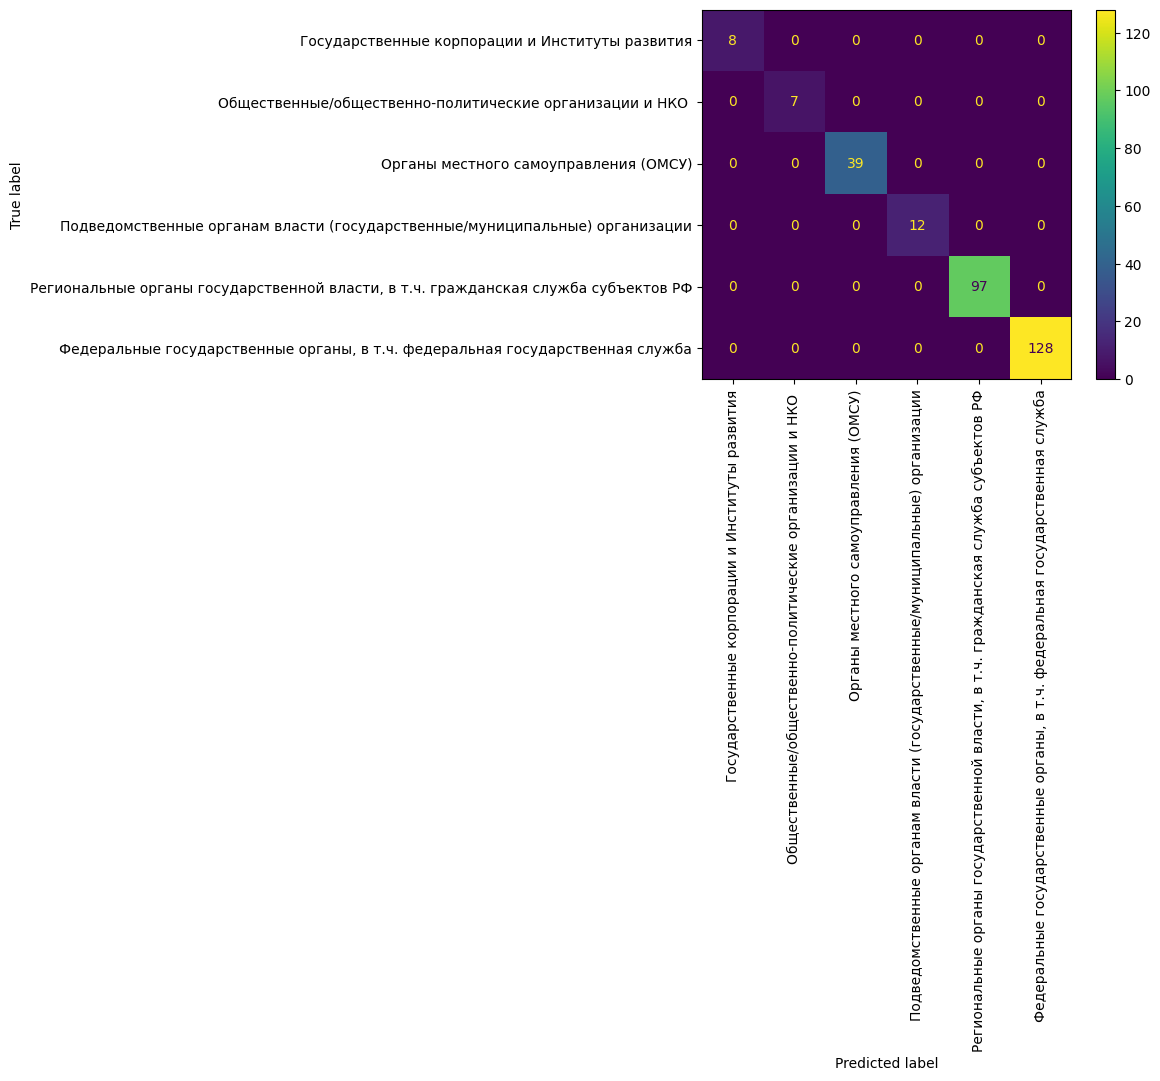

In [32]:
ConfusionMatrixDisplay.from_estimator(
    pipe, df_val, y_val, display_labels=LE.classes_[sorted(y_val.unique())], xticks_rotation="vertical"
)

## Метрики для - Карьерная ступень по Классификатору ФОИР

In [41]:
print(classification_report(y_val, y_pred,))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        46
           2       1.00      0.97      0.99        34
           3       1.00      1.00      1.00        38
           4       0.95      1.00      0.97        38
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00        57
           8       1.00      0.94      0.97        18
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00         4

    accuracy                           0.99       291
   macro avg       1.00      0.99      0.99       291
weighted avg       0.99      0.99      0.99       291



In [42]:
LE.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2736986/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2736986/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2736986/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens

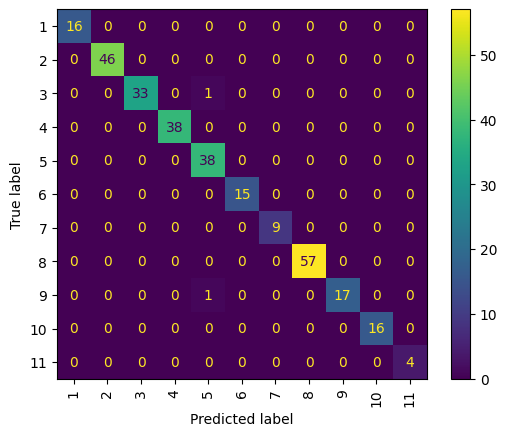

In [43]:
ConfusionMatrixDisplay.from_estimator(
    pipe, df_val, y_val, display_labels=LE.classes_[:-1], xticks_rotation="vertical"
)